In [1]:
from linkage.linkage import *
from vineyard import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline

## Download dataset to a variable and display it

We use an example dataset available at the accelerated HDBSCAN Git repository [https://github.com/scikit-learn-contrib/hdbscan] (McInnes, Healy, Astels).

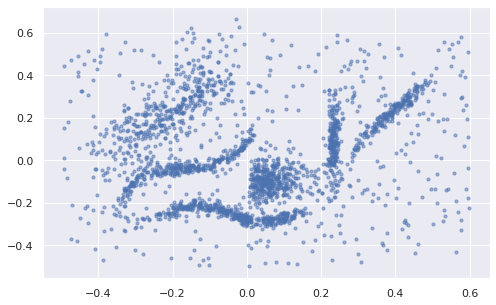

In [2]:
from urllib.request import urlopen
from io import BytesIO

url = "https://github.com/scikit-learn-contrib/hdbscan/blob/4052692af994610adc9f72486a47c905dd527c94/notebooks/clusterable_data.npy?raw=true"
f = urlopen(url)
rf = f.read()
X = np.load(BytesIO(rf))
fig1, ax1 = plt.subplots() ; fig1.set_figheight(5) ; fig1.set_figwidth(8) ; _ = plt.scatter(X.T[0], X.T[1], s=10, alpha = 0.5)

We run the algorithm with several choices of curve to see the evolution of the cluster structure as we vary the parameter. We see that there are six high persistence vines well separated from the rest.

In [5]:
x = MPSpace(X)
x.fit()

x0 = x.connection_radius()
initial_k = 0.01
final_k = 0.1
N_PARAMETERS = 20

gammas = [ Gamma_curve.linear_interpolator_alpha_s_indexed(k, x0) for k in np.linspace(initial_k, final_k, num=N_PARAMETERS) ]
PDs = [ x.gamma_linkage(curve).PD()[0] for curve in gammas ]

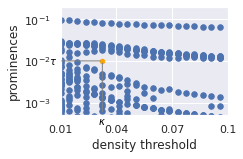

In [6]:
kappa = 0.03
tau = 0.01

plotProminenceVineyard(PDs, N_PARAMETERS, initial_k, final_k, kappa = kappa, tau = tau, s = 30, y_lim = [0.0005,0.2])

In [14]:
gamma = Gamma_curve.linear_interpolator_alpha_s_indexed(kappa, x0)
hc = x.gamma_linkage(gamma)
c = hc.persistence_based_flattening(threshold=tau)

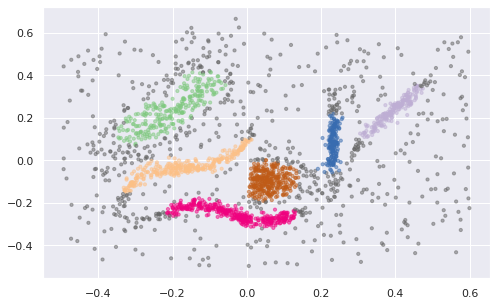

In [15]:
fig1, ax1 = plt.subplots() ; fig1.set_figheight(5) ; fig1.set_figwidth(8)
_ = plt.scatter(X.T[0], X.T[1], s=10, alpha = 0.5, c = -c[1], cmap="Accent")